# Predicting Default Payments with Fully-Connected NNs

The dataset contains information on default payments, demographic factors, credit data, history of payment, and bill statements of credit card clients in Taiwan from April 2005 to September 2005.

## Inspecting the data

any comment about data dimensionality/distribution goes here

In [138]:
import pandas as pd  
import numpy as np   
import os            

# Set TensorFlow logging level to avoid unnecessary warnings
# '1' means only error messages will be printed (ignoring warnings and info messages)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

def load_data(path, train=True):
    """
    Loads data from a CSV file and preprocesses it for machine learning tasks.
    
    Parameters:
    path (str): The file path to the CSV data.
    train (bool): Specifies if the data being loaded is for training (True) or testing (False).
    
    Returns:
    tuple: 
        - For training data: A tuple containing feature matrix (X) and labels (y).
        - For test data: A tuple containing feature matrix (X) and IDs (used for evaluation or submission purposes).
    
    The function operates in two modes:
    1. Training mode (`train=True`): The data is shuffled and split into features and labels.
    2. Test mode (`train=False`): The function skips the label column and loads the feature matrix and IDs.
    """
    
    # Read the CSV file using the specified encoding (ISO-8859-2). This encoding is often used for Western European languages.
    df = pd.read_csv(path, encoding="ISO-8859-2")
    
    if train:
        # Shuffle the training data to ensure that it is randomized before splitting
        # 'frac=1' keeps all the rows while shuffling the data
        # 'random_state=42' ensures reproducibility by using a fixed seed
        data = df.sample(frac=1, random_state=42).values
        
        # Return the feature matrix (all columns except the last) and the labels (last column)
        # Convert feature matrix to float32 for efficiency in numerical operations (especially useful for ML models)
        return data[:, :-1].astype(np.float32), data[:, -1]
    
    # For test data, return the features (from the second column onward) and IDs (the first column)
    # The test set does not have labels, hence the ID is returned for submission or evaluation purposes.
    return df.iloc[:, 1:].values.astype(np.float32), df.iloc[:, 0].astype(str)

# Load the training data (X_train: features, labels: target values)
X_train, labels = load_data('./train.csv')

# Load the test data (X_test: features, ids: unique identifiers for test samples)
X_test, ids = load_data('./test.csv', train=False)

# Display the dimensions of the training set (number of samples and features)
print(f"Training set dimensions: {X_train.shape}\nFeatures count: {X_train.shape[1]}")

# Display the first 5 rows of the training data (as a pandas DataFrame for readability)
print("\nFirst 5 training samples:\n", pd.DataFrame(X_train).head())

# Display the distribution of labels in the training set
# This is useful for understanding the class balance, which can affect the choice of model or metrics
print("\nLabels distribution:\n", pd.Series(labels).value_counts())

# Check and display the number of missing values per column in the training set
# This step is essential for identifying data quality issues before model training
print("\nMissing values:\n", pd.read_csv('./train.csv').isnull().sum())

# Show basic summary statistics (mean, standard deviation, etc.) for the training set
# Helps to get an overview of the data distribution, which can guide feature engineering or model selection
print("\nSummary statistics:\n", pd.read_csv('./train.csv').describe())

# Display the dimensions of the test set to ensure consistency between training and test features
print("\nTest set dimensions:", X_test.shape)

Training set dimensions: (25500, 24)
Features count: 24

First 5 training samples:
         0         1    2    3    4     5    6    7    8    9   ...       14  \
0  21870.0   70000.0  2.0  3.0  2.0  26.0  0.0  0.0  0.0  0.0  ...   8948.0   
1  15211.0  320000.0  2.0  2.0  2.0  28.0 -1.0 -1.0 -1.0 -1.0  ...    944.0   
2  20041.0   30000.0  2.0  2.0  2.0  36.0  0.0 -1.0 -1.0  0.0  ...  30452.0   
3   9190.0   20000.0  2.0  3.0  1.0  35.0  0.0  0.0  2.0  2.0  ...  18621.0   
4   6260.0   80000.0  1.0  2.0  2.0  32.0  1.0  2.0  0.0  0.0  ...  28242.0   

        15       16       17      18       19      20      21      22      23  
0   9006.0  10570.0  11421.0  2000.0   1200.0  1500.0  2000.0  1000.0  2000.0  
1    473.0   1747.0   1193.0   390.0    944.0   473.0  5000.0  1200.0   980.0  
2  29667.0  28596.0  29180.0   490.0  33299.0  1400.0   572.0   584.0   400.0  
3  18024.0  18434.0  19826.0  3000.0   1000.0     0.0   700.0  1700.0     0.0  
4  21400.0      0.0      0.0     7.0   12

## Preparing the data

describe the choice made during the preprocessing operations, also taking into account the previous considerations during the data inspection.

Missing values:
 ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64


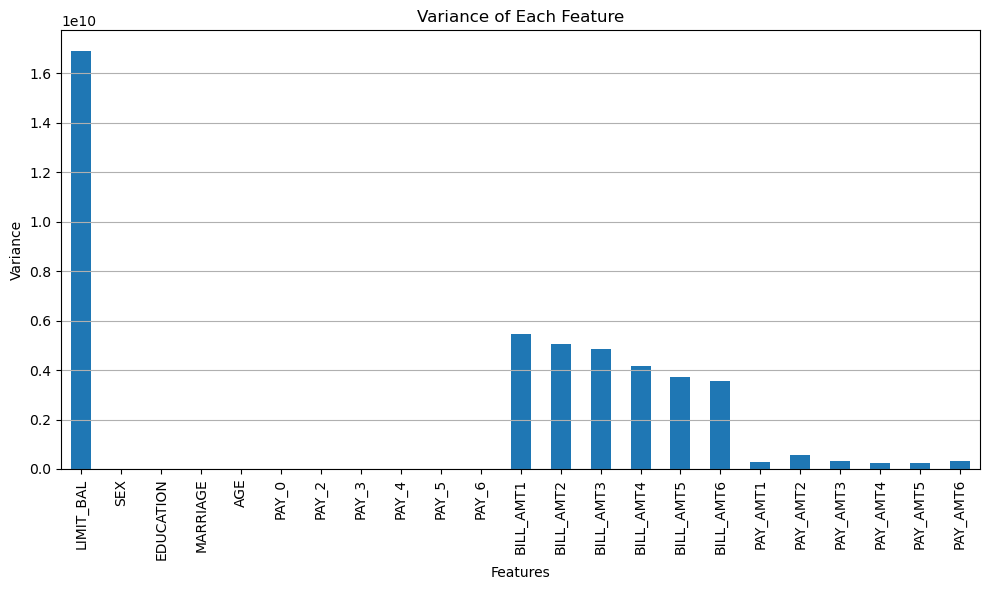

Shapes -> Train: (15300, 23), Val: (10200, 23), Encoded Train: (15300,), Encoded Val: (10200,)


In [139]:
import pandas as pd  
from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import StandardScaler 
import matplotlib.pyplot as plt 

def preprocess_data(X, scaler=None):
    """
    Preprocesses the input data by scaling the features using StandardScaler.
    
    Parameters:
    X (pd.DataFrame or np.array): Feature data to be scaled.
    scaler (StandardScaler, optional): Pre-fitted scaler object. If None, a new scaler will be fitted to the data.
    
    Returns:
    tuple:
        - Scaled feature matrix (np.array)
        - Fitted scaler (StandardScaler object)
    
    The function either uses an existing scaler to transform the data or fits a new one if none is provided.
    """
    # If no scaler is provided, fit a new StandardScaler to the data
    if scaler is None:
        scaler = StandardScaler().fit(X)
    
    # Transform the data using the fitted scaler
    return scaler.transform(X), scaler

# Load the training dataset
df_train = pd.read_csv('./train.csv')

# Extract the label column ('default payment next month') from the dataset
labels_raw = df_train['default payment next month']

# Specify columns to be dropped from the feature matrix (e.g., 'ID' and the label column)
columns_to_drop = ["ID"]

# Drop the specified columns and the label from the training dataset to create the feature matrix
X_train_raw = df_train.drop(columns=columns_to_drop + ['default payment next month'])

# Check for missing values in the dataset and print the count for each column
print("Missing values:\n", df_train.isnull().sum())

# Plot the variance of each feature in the dataset
plt.figure(figsize=(10, 6))  # Set the figure size for the plot
X_train_raw.var().plot(kind='bar')  # Plot variance as a bar chart
plt.title('Variance of Each Feature')  # Set plot title
plt.xlabel('Features')  # Label for x-axis
plt.ylabel('Variance')  # Label for y-axis
plt.xticks(rotation=90)  # Rotate feature names for better readability
plt.grid(axis='y')  # Add gridlines to y-axis for clarity
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Display the plot

# Split the dataset into training and validation sets (60% train, 40% validation)
# Stratify ensures that the class distribution is maintained in both train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_raw, labels_raw, 
                                                  test_size=0.4, random_state=42, stratify=labels_raw)

# Scale the training data using StandardScaler
X_train_scaled, scaler = preprocess_data(X_train)

# Use the same scaler to scale the validation data
X_val_scaled, _ = preprocess_data(X_val, scaler)

# Output the shapes of the scaled training and validation datasets as well as their corresponding label sets
print(f"Shapes -> Train: {X_train_scaled.shape}, Val: {X_val_scaled.shape}, "
      f"Encoded Train: {y_train.shape}, Encoded Val: {y_val.shape}")

## Building the network

any description/comment about the procedure you followed in the choice of the network structure and hyperparameters goes here, together with consideration about the training/optimization procedure (e.g. optimizer choice, final activations, loss functions, training metrics)

In [141]:
from keras.optimizers import Adam  
from keras.layers import Dense, BatchNormalization, Dropout  
from keras.models import Sequential  
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback  
from sklearn.metrics import f1_score 
from keras.layers import Input  

def build_model(input_shape):
    """
    Builds a fully connected neural network model with regularization and batch normalization.
    
    Parameters:
    input_shape (int): The number of input features (shape of the input data).
    
    Returns:
    model (Sequential): A compiled Keras model ready for training.
    """
    model = Sequential()
    
    # Input layer with specified input shape
    model.add(Input(shape=(input_shape,)))
    
    # First hidden layer with 512 units, ReLU activation, L2 regularization, and batch normalization
    model.add(Dense(512, activation='relu', kernel_regularizer='l2'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))  # Dropout to reduce overfitting
    
    # Second hidden layer with 256 units, ReLU activation, L2 regularization, and batch normalization
    model.add(Dense(256, activation='relu', kernel_regularizer='l2'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    # Third hidden layer with 128 units, ReLU activation, L2 regularization, and batch normalization
    model.add(Dense(128, activation='relu', kernel_regularizer='l2'))
    model.add(BatchNormalization())
    
    # Output layer with sigmoid activation for binary classification
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model with Adam optimizer, binary cross-entropy loss, and accuracy metric
    model.compile(optimizer=Adam(learning_rate=0.0001), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    return model

# Retrieve the number of input features from the training data
input_shape = X_train_scaled.shape[1]  
model = build_model(input_shape)  # Build the model

# Set hyperparameters for training
batch_size = 64
epochs = 80  # Define the number of epochs for training

# Display the model summary for understanding the architecture
model.summary()

# EarlyStopping: Stops training when the validation loss does not improve for 10 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# ReduceLROnPlateau: Reduces the learning rate by a factor of 0.5 when the validation loss plateaus for 10 epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, min_lr=1e-6)

# Custom callback to display progress during training with more informative outputs
class ProgressBar(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch = epoch
    
    def on_epoch_end(self, epoch, logs=None):
        metrics = (f"Epoch {self.epoch + 1}/{self.params['epochs']} - "
                   f"Loss: {logs['loss']:.4f} - "
                   f"Val Loss: {logs['val_loss']:.4f} - "
                   f"Accuracy: {logs['accuracy']:.4f} - "
                   f"Val Accuracy: {logs['val_accuracy']:.4f}")
        print("\r" + metrics, end='')

# Train the model with training data, using early stopping, learning rate reduction, and custom progress bar
history = model.fit(X_train_scaled, y_train, 
                    validation_data=(X_val_scaled, y_val),  # Validation set to monitor during training
                    epochs=epochs, batch_size=batch_size, 
                    callbacks=[early_stopping, reduce_lr, ProgressBar()],  # List of callbacks
                    verbose=1)

# Evaluate the model on the validation set and print the loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_scaled, y_val, verbose=0)

# Display the final validation results
print()
print("\nRESULTS:")
print(f"{'Validation Loss:':<20} {val_loss:.4f}")
print(f"{'Validation Accuracy:':<20} {val_accuracy:.4f}")

# Predict probabilities for the validation set
y_pred_prob = model.predict(X_val_scaled, verbose=0) 

# Convert probabilities to binary predictions (threshold at 0.5)
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate and print the F1 score, which is useful for evaluating imbalanced datasets
f1 = f1_score(y_val, y_pred)
print(f"{'F1 Score:':<20} {f1:.4f}")

Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_127 (Dense)               │ (None, 512)            │        12,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_97          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_67 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_128 (Dense)               │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_98          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_68 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_129 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_99          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_130 (Dense)               │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 180,225 (704.00 KB)

 Trainable params: 178,433 (697.00 KB)

 Non-trainable params: 1,792 (7.00 KB)

Epoch 1/80
240/240 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5595 - loss: 6.1598 - val_accuracy: 0.8075 - val_loss: 5.3129 - learning_rate: 1.0000e-04
Epoch 2/80
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6980 - loss: 5.2211 - val_accuracy: 0.8039 - val_loss: 4.6203 - learning_rate: 1.0000e-04
Epoch 3/80
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7528 - loss: 4.4866 - val_accuracy: 0.8129 - val_loss: 3.9988 - learning_rate: 1.0000e-04
Epoch 4/80
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7833 - loss: 3.8959 - val_accuracy: 0.8160 - val_loss: 3.4817 - learning_rate: 1.0000e-04
Epoch 5/80
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7848 - loss: 3.4076 - val_accuracy: 0.8167 - val_loss: 3.0643 - learning_rate: 1.0000e-04
Epoch 6/80
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7935 - loss: 3.0207 - val_accuracy: 0.8165 - val_loss: 2.7260 - learning_rate: 1.0000e-04
Epoch 7/80
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 

## Analyze and comment the training results

here goes any comment/visualization of the training history and any initial consideration on the training results  

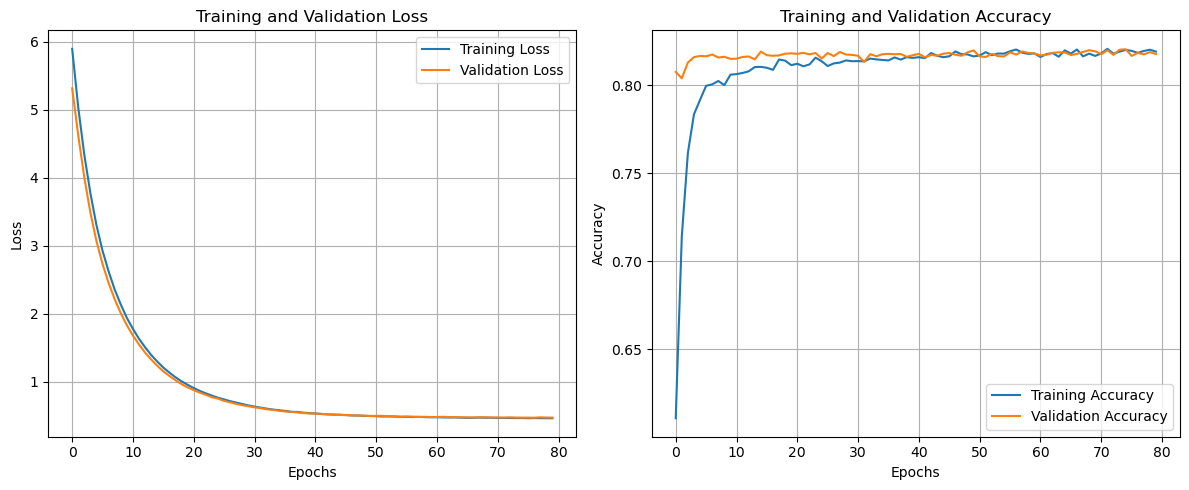

Final Training Loss: 0.4600
Final Validation Loss: 0.4696
Final Training Accuracy: 0.8192
Final Validation Accuracy: 0.8177
The model performs better on the training set compared to the validation set, which might indicate overfitting.


In [142]:
import matplotlib.pyplot as plt 

def plot_training_history(history):
    """
    Plots the training and validation loss and accuracy over epochs.
    
    Parameters:
    history: History object returned from model.fit() that contains training and validation metrics for each epoch.
    
    The function generates two subplots: one for loss and one for accuracy, for both the training and validation sets.
    """
    plt.figure(figsize=(12, 5))  # Set the size of the plot figure

    # Plot training and validation loss
    plt.subplot(1, 2, 1)  # Create a subplot for loss (1 row, 2 columns, 1st plot)
    plt.plot(history.history['loss'], label='Training Loss')  # Plot training loss
    plt.plot(history.history['val_loss'], label='Validation Loss')  # Plot validation loss
    plt.title('Training and Validation Loss')  # Set the title of the plot
    plt.xlabel('Epochs')  # Label x-axis as 'Epochs'
    plt.ylabel('Loss')  # Label y-axis as 'Loss'
    plt.legend()  # Add a legend to differentiate between training and validation
    plt.grid()  # Add a grid for better readability

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)  # Create a subplot for accuracy (1 row, 2 columns, 2nd plot)
    plt.plot(history.history['accuracy'], label='Training Accuracy')  # Plot training accuracy
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  # Plot validation accuracy
    plt.title('Training and Validation Accuracy')  # Set the title of the plot
    plt.xlabel('Epochs')  # Label x-axis as 'Epochs'
    plt.ylabel('Accuracy')  # Label y-axis as 'Accuracy'
    plt.legend()  # Add a legend to differentiate between training and validation
    plt.grid()  # Add a grid for better readability

    plt.tight_layout()  # Adjust the layout to prevent overlap between subplots
    plt.show()  # Display the plots

# Call the function to plot training history
plot_training_history(history)

# Extract the final training and validation loss and accuracy from the history object
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
final_train_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]

# Print final metrics for training and validation
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")
print(f"Final Training Accuracy: {final_train_accuracy:.4f}")
print(f"Final Validation Accuracy: {final_val_accuracy:.4f}")

# Compare training and validation performance and interpret the results
if final_train_loss < final_val_loss:
    print("The model performs better on the training set compared to the validation set, which might indicate overfitting.")
elif final_train_loss > final_val_loss:
    print("The model performs better on the validation set compared to the training set, indicating potential underfitting.")
else:
    print("The model performs similarly on both sets, suggesting a good fit.")

## Validate the model and comment the results

please describe the evaluation procedure on a validation set, commenting the generalization capability of your model (e.g. under/overfitting). You may also describe the performance metrics that you choose: what is the most suitable performance measure (or set of performance measures) in this case/dataset, according to you? Why?

In [143]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# Predict the probabilities for the validation set
y_val_pred_prob = model.predict(X_val_scaled)

# Convert predicted probabilities to binary predictions using a threshold of 0.5
y_val_pred = (y_val_pred_prob > 0.5).astype(int)

# Generate the confusion matrix to compare actual vs predicted values
confusion = confusion_matrix(y_val, y_val_pred)
print("Confusion Matrix:")
print(confusion)

# Create a detailed classification report including precision, recall, and F1-score
class_report = classification_report(y_val, y_val_pred, target_names=["No Default", "Default"])
print("Classification Report:")
print(class_report)

# Calculate the ROC AUC score using the predicted probabilities
roc_auc = roc_auc_score(y_val, y_val_pred_prob)
print(f"ROC AUC Score: {roc_auc:.4f}")

319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Confusion Matrix:
[[7442  484]
 [1368  906]]
Classification Report:
              precision    recall  f1-score   support

  No Default       0.84      0.94      0.89      7926
     Default       0.65      0.40      0.49      2274

    accuracy                           0.82     10200
   macro avg       0.75      0.67      0.69     10200
weighted avg       0.80      0.82      0.80     10200

ROC AUC Score: 0.7763


## Make predictions (on the provided test set)

Based on the results obtained and analyzed during the training and the validation phases, what are your (rather _personal_) expectations with respect to the performances of your model on the blind external test set? Briefly motivate your answer.

In [144]:
import pandas as pd  

# Load the test dataset from a CSV file
test_df = pd.read_csv('test.csv')

# Drop the 'ID' column if it exists, as it is not needed for predictions
if 'ID' in test_df.columns:
    test_df = test_df.drop(columns=['ID'])

# Copy the test dataset to preserve the original data structure
X_test = test_df.copy()

# Ensure that the number of features in the test set matches the expected number of features
if X_test.shape[1] == scaler.n_features_in_:
    # Standardize the test set using the same scaler fitted on the training data
    X_test_scaled = scaler.transform(X_test)
else:
    # Raise an error if the number of columns does not match the training data
    raise ValueError("Impossibile standardizzare i dati: il numero di colonne non corrisponde.")

# Predict the probabilities for the test set using the trained model
test_predictions_prob = model.predict(X_test_scaled)

# Convert predicted probabilities to binary class predictions using a threshold of 0.5
test_predictions = (test_predictions_prob > 0.5).astype(int)

# Save the predictions to a CSV file without including the header or index
pd.DataFrame(test_predictions, columns=['Predicted']).to_csv('test_predictions.csv', index=False, header=False)

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [145]:
from sklearn.metrics import accuracy_score, f1_score

true_labels_df = pd.read_csv('test_with_labels_real.csv', header=None)  
true_labels = true_labels_df[0].values 

predictions_df = pd.read_csv('test_predictions.csv', header=None)
predictions = predictions_df[0].values 

accuracy = accuracy_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)

print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')


Accuracy: 0.8256
F1 Score: 0.4886


# OPTIONAL -- Export the predictions in the format indicated in the assignment release page and verify you prediction on the [assessment page](https://aml-assignmentone-2425.streamlit.app/).